In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('Health_Risk_Dataset.csv')
data.head()

,Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
0,P0522,25,96,1,97,107,37.5,A,0,Medium
1,P0738,28,92,2,116,151,38.5,P,1,High
2,P0741,29,91,1,79,135,38.4,A,0,High
3,P0661,24,96,1,95,92,37.3,A,0,Medium
4,P0412,20,96,1,97,97,37.4,A,0,Low


In [9]:
# Check basic info about the dataset
print("Dataset Shape:", data.shape)
print("\nColumn Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nRisk Level Distribution:")
print(data['Risk_Level'].value_counts())
print("\nBasic Statistics:")
print(data.describe())

Dataset Shape: (1000, 10)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         1000 non-null   object 
 1   Respiratory_Rate   1000 non-null   int64  
 2   Oxygen_Saturation  1000 non-null   int64  
 3   O2_Scale           1000 non-null   int64  
 4   Systolic_BP        1000 non-null   int64  
 5   Heart_Rate         1000 non-null   int64  
 6   Temperature        1000 non-null   float64
 7   Consciousness      1000 non-null   object 
 8   On_Oxygen          1000 non-null   int64  
 9   Risk_Level         1000 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB
None

Missing Values:
Patient_ID           0
Respiratory_Rate     0
Oxygen_Saturation    0
O2_Scale             0
Systolic_BP          0
Heart_Rate           0
Temperature          0
Consciousness        0
On_Oxygen

In [10]:
# Separate numerical and categorical features
numerical_cols = ['Respiratory_Rate', 'Oxygen_Saturation', 'O2_Scale', 'Systolic_BP', 
                  'Heart_Rate', 'Temperature', 'On_Oxygen']
categorical_cols = ['Consciousness']

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)
print("\nUnique values in Consciousness:", data['Consciousness'].unique())


Numerical columns: ['Respiratory_Rate', 'Oxygen_Saturation', 'O2_Scale', 'Systolic_BP', 'Heart_Rate', 'Temperature', 'On_Oxygen']
Categorical columns: ['Consciousness']

Unique values in Consciousness: ['A' 'P' 'V' 'U' 'C']


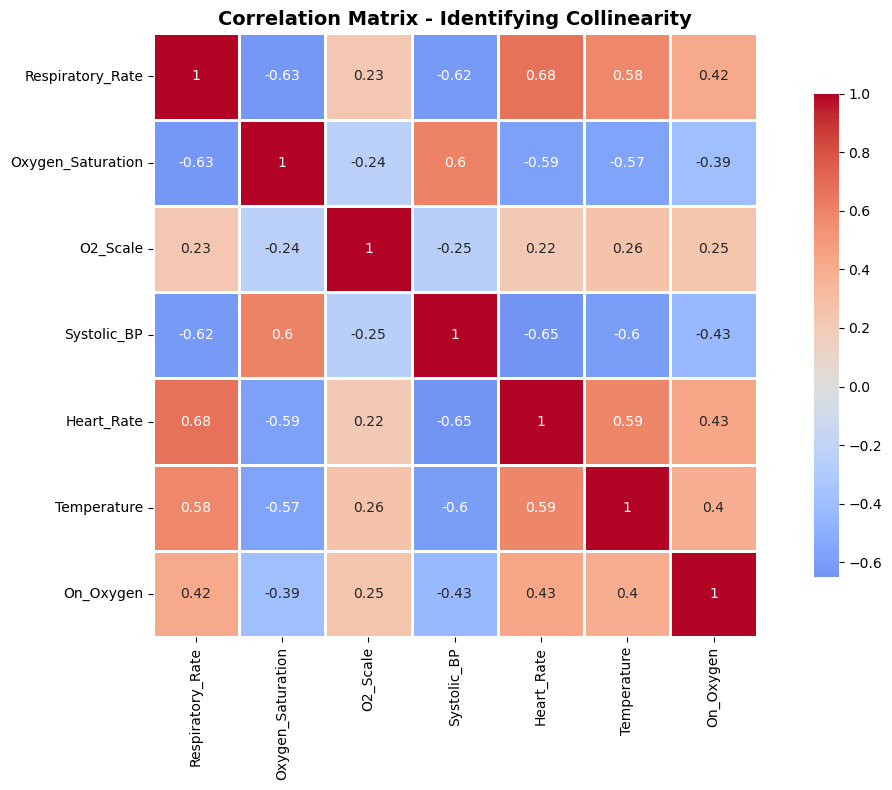

In [12]:
# Correlation analysis to identify collinearity
correlation_matrix = data[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Identifying Collinearity', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [15]:
# Identify highly correlated pairs (potential collinearity)
threshold = 0.7  # Correlation threshold for collinearity
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= threshold:
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated pairs (|r| >= {threshold}):")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature1']} <-> {pair['Feature2']}: {pair['Correlation']:.3f}")
else:
    print(f"No highly correlated pairs found (threshold: {threshold})")


No highly correlated pairs found (threshold: 0.7)


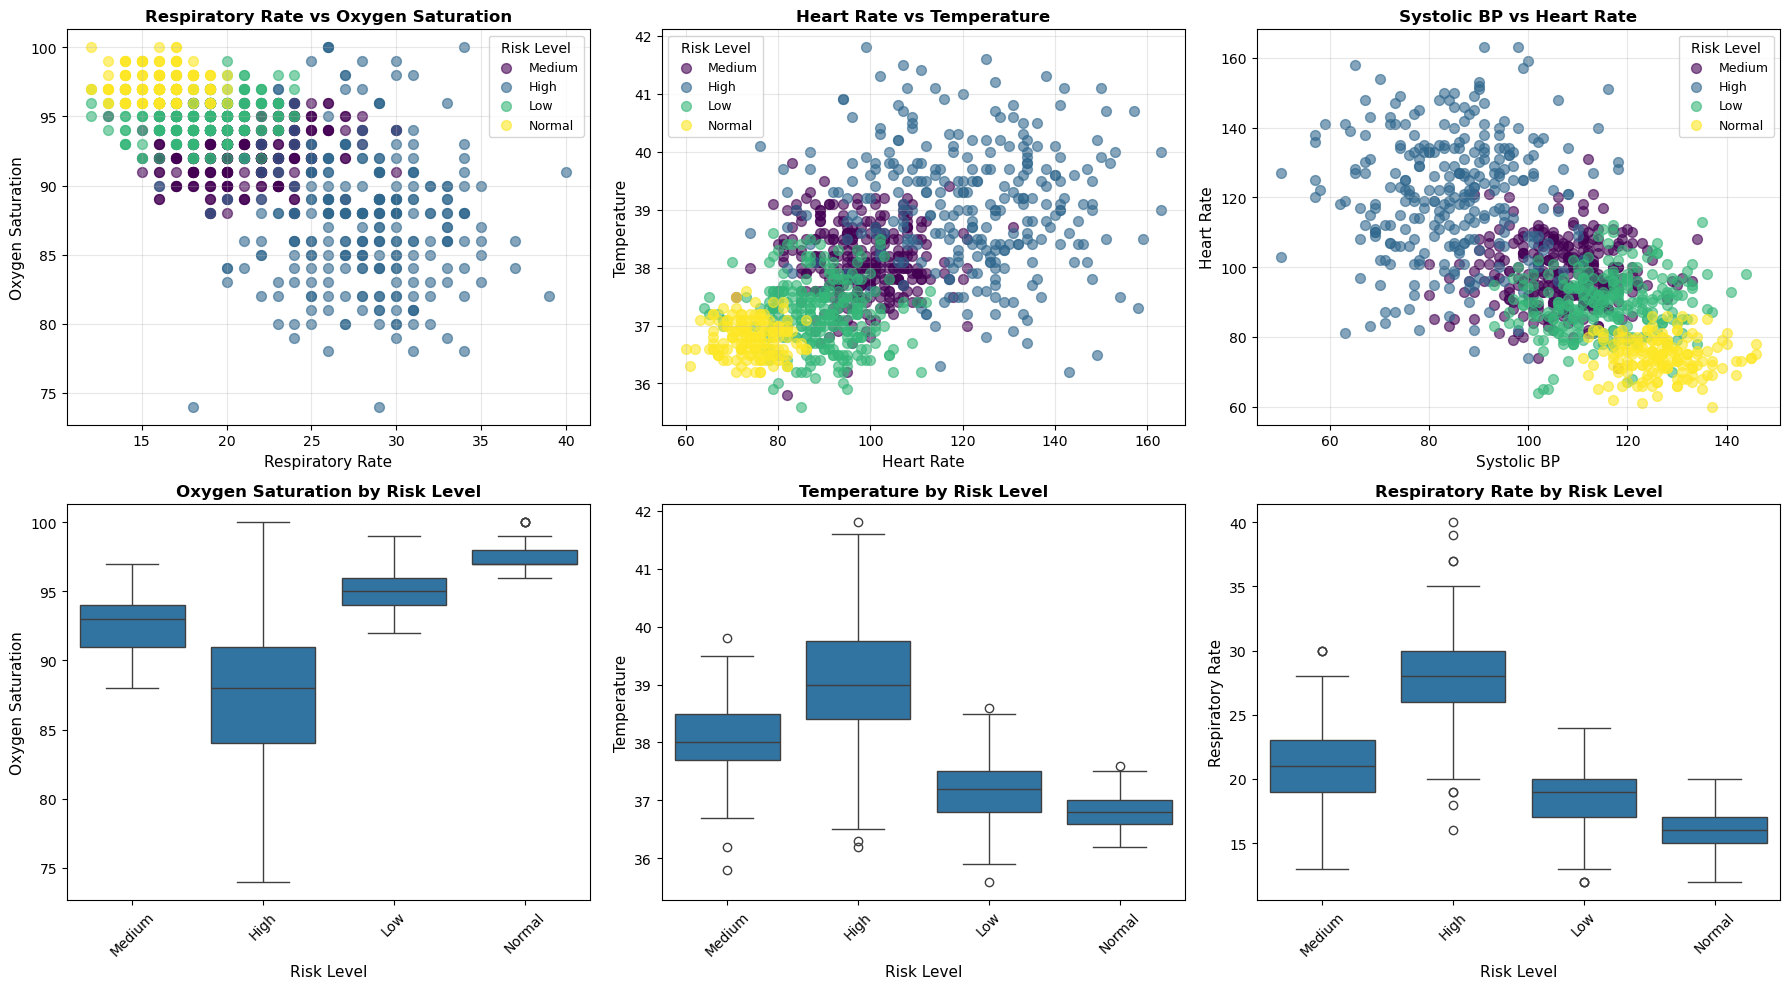

In [26]:
# Visualize relationships between key variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Get unique risk levels and assign colors
risk_levels = data['Risk_Level'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(risk_levels)))
color_map = dict(zip(risk_levels, colors))

# Respiratory Rate vs Oxygen Saturation
for risk_level in risk_levels:
    mask = data['Risk_Level'] == risk_level
    axes[0, 0].scatter(data.loc[mask, 'Respiratory_Rate'], 
                       data.loc[mask, 'Oxygen_Saturation'],
                       c=[color_map[risk_level]], label=risk_level, alpha=0.6, s=50)
axes[0, 0].set_xlabel('Respiratory Rate', fontsize=11)
axes[0, 0].set_ylabel('Oxygen Saturation', fontsize=11)
axes[0, 0].set_title('Respiratory Rate vs Oxygen Saturation', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(title='Risk Level', fontsize=9, title_fontsize=10)

# Heart Rate vs Temperature
for risk_level in risk_levels:
    mask = data['Risk_Level'] == risk_level
    axes[0, 1].scatter(data.loc[mask, 'Heart_Rate'], 
                       data.loc[mask, 'Temperature'],
                       c=[color_map[risk_level]], label=risk_level, alpha=0.6, s=50)
axes[0, 1].set_xlabel('Heart Rate', fontsize=11)
axes[0, 1].set_ylabel('Temperature', fontsize=11)
axes[0, 1].set_title('Heart Rate vs Temperature', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(title='Risk Level', fontsize=9, title_fontsize=10)

# Systolic BP vs Heart Rate
for risk_level in risk_levels:
    mask = data['Risk_Level'] == risk_level
    axes[0, 2].scatter(data.loc[mask, 'Systolic_BP'], 
                       data.loc[mask, 'Heart_Rate'],
                       c=[color_map[risk_level]], label=risk_level, alpha=0.6, s=50)
axes[0, 2].set_xlabel('Systolic BP', fontsize=11)
axes[0, 2].set_ylabel('Heart Rate', fontsize=11)
axes[0, 2].set_title('Systolic BP vs Heart Rate', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend(title='Risk Level', fontsize=9, title_fontsize=10)

# Box plots for key features by Risk Level
sns.boxplot(data=data, x='Risk_Level', y='Oxygen_Saturation', ax=axes[1, 0])
axes[1, 0].set_title('Oxygen Saturation by Risk Level', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Risk Level', fontsize=11)
axes[1, 0].set_ylabel('Oxygen Saturation', fontsize=11)
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=data, x='Risk_Level', y='Temperature', ax=axes[1, 1])
axes[1, 1].set_title('Temperature by Risk Level', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Risk Level', fontsize=11)
axes[1, 1].set_ylabel('Temperature', fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=45)

sns.boxplot(data=data, x='Risk_Level', y='Respiratory_Rate', ax=axes[1, 2])
axes[1, 2].set_title('Respiratory Rate by Risk Level', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Risk Level', fontsize=11)
axes[1, 2].set_ylabel('Respiratory Rate', fontsize=11)
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [28]:
# Prepare features - handle collinearity by selecting features
# Based on correlation analysis, we'll use all features but be aware of relationships
# If needed, we can remove highly correlated features later

# Create feature matrix
X = data[numerical_cols + categorical_cols].copy()
y = data['Risk_Level'].copy()

# Encode categorical variables
# Encode Consciousness
le_consciousness = LabelEncoder()
X['Consciousness_encoded'] = le_consciousness.fit_transform(X['Consciousness'])
X = X.drop('Consciousness', axis=1)

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("Feature matrix shape:", X.shape)
print("\nFeatures used:", X.columns.tolist())
print("\nTarget variable encoding:")
for i, level in enumerate(le_target.classes_):
    print(f"  {level}: {i}")


Feature matrix shape: (1000, 8)

Features used: ['Respiratory_Rate', 'Oxygen_Saturation', 'O2_Scale', 'Systolic_BP', 'Heart_Rate', 'Temperature', 'On_Oxygen', 'Consciousness_encoded']

Target variable encoding:
  High: 0
  Low: 1
  Medium: 2
  Normal: 3


In [36]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")


Training set size: 800
Test set size: 200

Features scaled successfully!


In [37]:
# K-Fold Cross-Validation to find optimal k and minimize error
# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Test different k values for KNN
k_values = range(1, 31)
cv_scores = []

print("Testing different k values using 5-fold cross-validation...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean())
    if k % 5 == 0:
        print(f"k={k}: Mean CV Accuracy = {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# Find optimal k
optimal_k = k_values[np.argmax(cv_scores)]
print(f"\nOptimal k: {optimal_k} with CV accuracy: {max(cv_scores):.4f}")


Testing different k values using 5-fold cross-validation...
k=5: Mean CV Accuracy = 0.9488 (+/- 0.0436)
k=10: Mean CV Accuracy = 0.9475 (+/- 0.0451)
k=15: Mean CV Accuracy = 0.9338 (+/- 0.0504)
k=20: Mean CV Accuracy = 0.9363 (+/- 0.0443)
k=25: Mean CV Accuracy = 0.9262 (+/- 0.0348)
k=30: Mean CV Accuracy = 0.9225 (+/- 0.0359)

Optimal k: 4 with CV accuracy: 0.9537


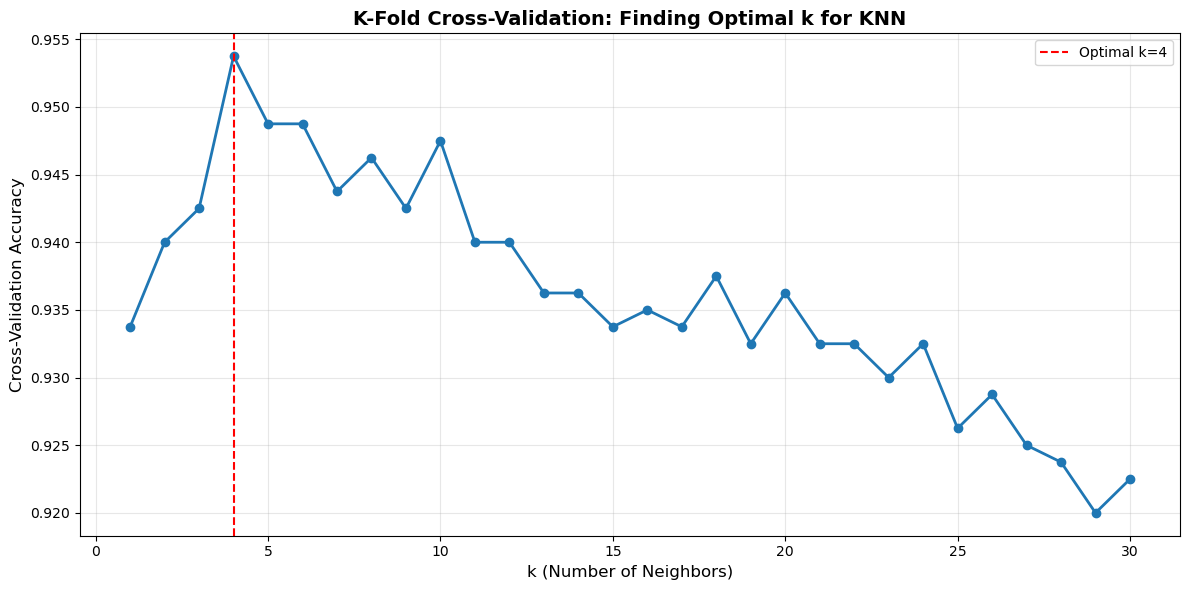

In [38]:
# Visualize k values vs cross-validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('K-Fold Cross-Validation: Finding Optimal k for KNN', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Test Set Accuracy: 0.9750

Classification Report:
              precision    recall  f1-score   support

        High       0.98      0.98      0.98        56
         Low       0.94      1.00      0.97        51
      Medium       0.98      0.95      0.97        61
      Normal       1.00      0.97      0.98        32

    accuracy                           0.97       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.97      0.98       200



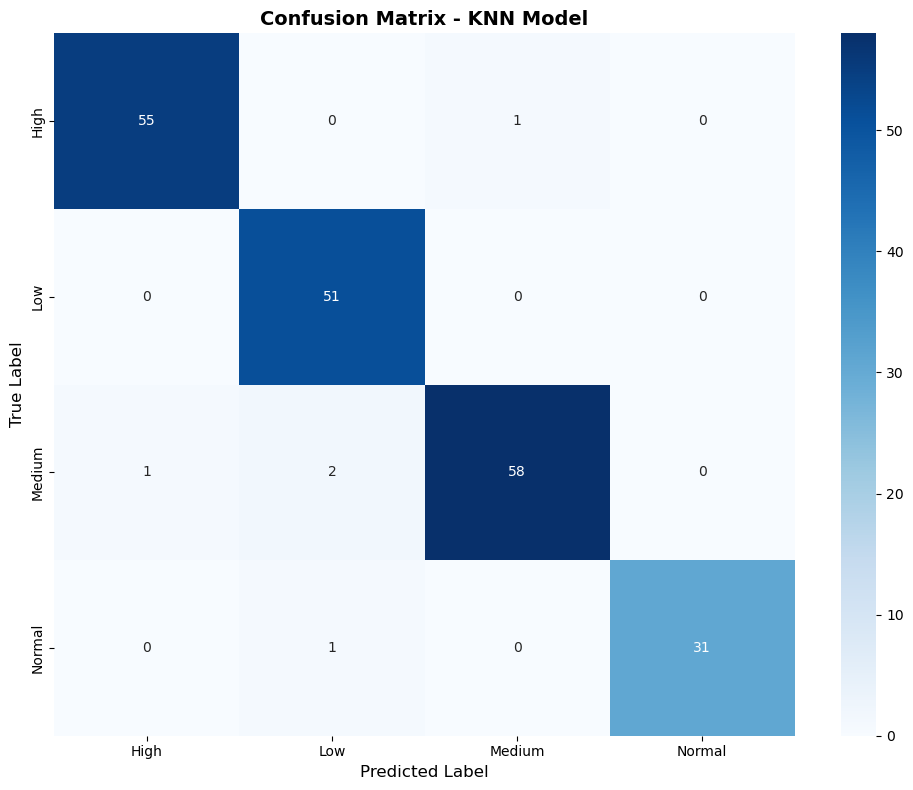

In [39]:
# Train final KNN model with optimal k
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = knn_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.4f}")

# Detailed performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_)
plt.title('Confusion Matrix - KNN Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


Feature Importance (Permutation Importance):
                 Feature  Importance       Std
0       Respiratory_Rate      0.2345  0.027060
1      Oxygen_Saturation      0.2245  0.025928
3            Systolic_BP      0.1955  0.030777
4             Heart_Rate      0.1880  0.011662
5            Temperature      0.1640  0.013191
6              On_Oxygen      0.0800  0.021331
2               O2_Scale      0.0520  0.011000
7  Consciousness_encoded      0.0510  0.012610


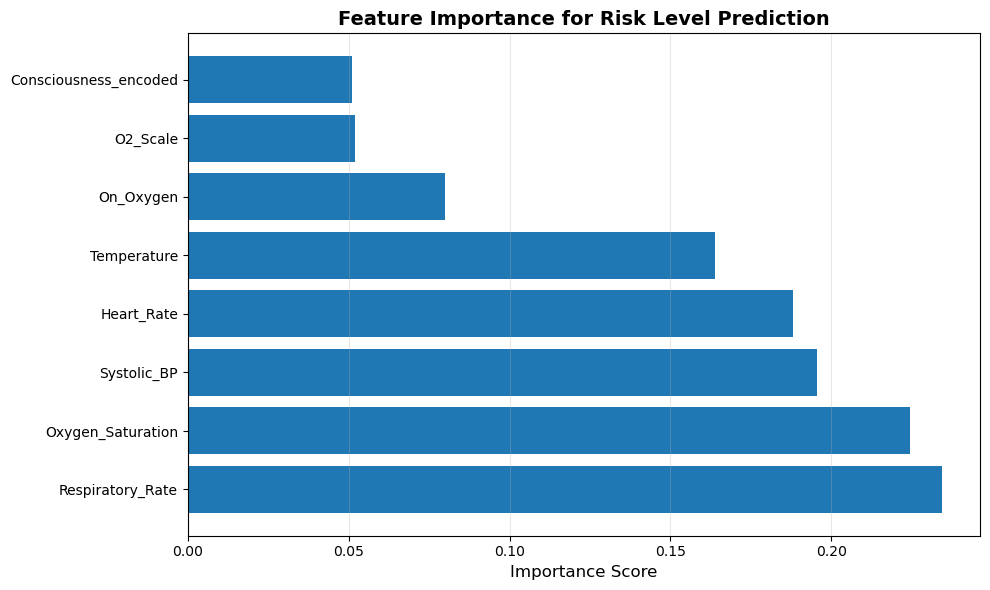

In [40]:
# Feature importance analysis using permutation importance
# Calculate permutation importance
perm_importance = permutation_importance(
    knn_model, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, scoring='accuracy'
)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("Feature Importance (Permutation Importance):")
print(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance for Risk Level Prediction', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [34]:
# Function to make predictions for new patients
def predict_risk_level(respiratory_rate, oxygen_saturation, o2_scale, systolic_bp, 
                       heart_rate, temperature, consciousness, on_oxygen):
    """
    Predict risk level for a new patient
    
    Parameters:
    - respiratory_rate: Respiratory rate (breaths per minute)
    - oxygen_saturation: Oxygen saturation percentage
    - o2_scale: O2 scale (1 or 2)
    - systolic_bp: Systolic blood pressure
    - heart_rate: Heart rate (beats per minute)
    - temperature: Body temperature
    - consciousness: Consciousness level ('A', 'P', 'U', or 'V')
    - on_oxygen: Whether patient is on oxygen (0 or 1)
    
    Returns:
    - Predicted risk level
    """
    # Create feature array
    features = np.array([[respiratory_rate, oxygen_saturation, o2_scale, systolic_bp, 
                          heart_rate, temperature, on_oxygen]])
    
    # Encode consciousness
    consciousness_encoded = le_consciousness.transform([consciousness])[0]
    features = np.append(features[0], consciousness_encoded).reshape(1, -1)
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    prediction_encoded = knn_model.predict(features_scaled)[0]
    prediction = le_target.inverse_transform([prediction_encoded])[0]
    
    # Get prediction probabilities
    probabilities = knn_model.predict_proba(features_scaled)[0]
    prob_dict = {le_target.classes_[i]: prob for i, prob in enumerate(probabilities)}
    
    return prediction, prob_dict

# Example predictions
print("Example Predictions:")
print("=" * 60)

# Example 1: High risk patient
pred1, prob1 = predict_risk_level(30, 85, 2, 90, 130, 39.5, 'A', 1)
print(f"\nPatient 1 - High Risk Indicators:")
print(f"  Respiratory Rate: 30, O2 Sat: 85%, Temp: 39.5°C, On Oxygen: Yes")
print(f"  Predicted Risk Level: {pred1}")
print(f"  Probabilities: {prob1}")

# Example 2: Low risk patient
pred2, prob2 = predict_risk_level(18, 97, 1, 120, 85, 37.0, 'A', 0)
print(f"\nPatient 2 - Low Risk Indicators:")
print(f"  Respiratory Rate: 18, O2 Sat: 97%, Temp: 37.0°C, On Oxygen: No")
print(f"  Predicted Risk Level: {pred2}")
print(f"  Probabilities: {prob2}")

# Example 3: Medium risk patient
pred3, prob3 = predict_risk_level(24, 92, 1, 110, 100, 38.0, 'A', 0)
print(f"\nPatient 3 - Medium Risk Indicators:")
print(f"  Respiratory Rate: 24, O2 Sat: 92%, Temp: 38.0°C, On Oxygen: No")
print(f"  Predicted Risk Level: {pred3}")
print(f"  Probabilities: {prob3}")


Example Predictions:

Patient 1 - High Risk Indicators:
  Respiratory Rate: 30, O2 Sat: 85%, Temp: 39.5°C, On Oxygen: Yes
  Predicted Risk Level: High
  Probabilities: {'High': np.float64(1.0), 'Low': np.float64(0.0), 'Medium': np.float64(0.0), 'Normal': np.float64(0.0)}

Patient 2 - Low Risk Indicators:
  Respiratory Rate: 18, O2 Sat: 97%, Temp: 37.0°C, On Oxygen: No
  Predicted Risk Level: Normal
  Probabilities: {'High': np.float64(0.0), 'Low': np.float64(0.25), 'Medium': np.float64(0.0), 'Normal': np.float64(0.75)}

Patient 3 - Medium Risk Indicators:
  Respiratory Rate: 24, O2 Sat: 92%, Temp: 38.0°C, On Oxygen: No
  Predicted Risk Level: Medium
  Probabilities: {'High': np.float64(0.0), 'Low': np.float64(0.0), 'Medium': np.float64(1.0), 'Normal': np.float64(0.0)}


In [ ]:
# Summary of model performance and key findings
print("=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
print(f"\n1. Optimal k value: {optimal_k}")
print(f"2. Cross-Validation Accuracy: {max(cv_scores):.4f}")
print(f"3. Test Set Accuracy: {accuracy:.4f}")

print("\n4. Collinearity Analysis:")
if high_corr_pairs:
    print("   Found highly correlated features:")
    for pair in high_corr_pairs:
        print(f"   - {pair['Feature1']} <-> {pair['Feature2']}: {pair['Correlation']:.3f}")
else:
    print("   No significant collinearity detected (threshold: 0.7)")

print("\n5. Most Important Features:")
for idx, row in feature_importance_df.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

print("\n6. Model is ready to make predictions using the predict_risk_level() function!")
print("=" * 60)


MODEL SUMMARY

1. Optimal k value: 4
2. Cross-Validation Accuracy: 0.9537
3. Test Set Accuracy: 0.9750

4. Collinearity Analysis:
   No significant collinearity detected (threshold: 0.7)

5. Most Important Features:
   Respiratory_Rate: 0.2345
   Oxygen_Saturation: 0.2245
   Systolic_BP: 0.1955
   Heart_Rate: 0.1880
   Temperature: 0.1640

6. Model is ready to make predictions using the predict_risk_level() function!
